In [1]:
import csv
import numpy as np
import scipy
import nltk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression as sklearn_LR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\megk2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def load_data(filename):
    '''
    Method for loading in data from tsv.
    
    Input:
    - filename (str): tsv file containing annotated data must include
                      header with the named columns "label" and "text"

    Returns a lists of strings corresponding to the document texts
    and labels respectively
    '''
    with open(filename, encoding="utf-8", newline='') as tsv:
        reader = csv.DictReader(tsv, delimiter='\t')
        
        texts, labels = [], []
        for row in reader:
            texts.append(row['text'])
            labels.append(row['label'])

    return texts, labels

In [3]:
def text_to_feature_vectors(train, dev, test):
    '''
    Note that texts are lowercased and that we only include
    word types that occur in at least 5 documents within the
    training split.
    '''
    binary_bow_vectorizer = CountVectorizer(lowercase=True,
                                            tokenizer=nltk.word_tokenize,
                                            binary=True,
                                            min_df=5
                                           )
    train_vecs = binary_bow_vectorizer.fit_transform(train)
    dev_vecs = binary_bow_vectorizer.transform(dev)
    test_vecs = binary_bow_vectorizer.transform(test)
    vocab_index = binary_bow_vectorizer.vocabulary_
    vocab = sorted(vocab_index.keys(), key=lambda x: vocab_index[x])
    
    return {
        "vocab": vocab,
        "vocab_index": binary_bow_vectorizer.vocabulary_,
        "train": train_vecs,
        "dev": dev_vecs,
        "test": test_vecs
    }

In [4]:
class Classifier:
    '''
    A l2-regularized logistic regression classifier 
    '''
    def __init__(self):
        self.model = None
        self.C = -1

    def train_and_optimize(self, train_vectors, train_labels,
                            dev_vectors, dev_labels):
        assert not self.model, "ERROR: Model already trained."
        best_C = -1
        best_score = 0
        best_model = None
        for C in [0.1, 1, 10, 100]:
            model = sklearn_LR(C=C, max_iter=1000)
            model.fit(train_vectors, train_labels)
            train_acc = model.score(train_vectors, train_labels)
            dev_acc = model.score(dev_vectors, dev_labels)
            print("C = {} - Train Accuracy: {:.3f}, Dev Accuracy: {:.3f}".format(
                  C, train_acc, dev_acc))
            if dev_acc > best_score:
                best_C = C
                best_model = model
                best_score = dev_acc
        print("Selected C = {}".format(best_C))
        self.C = best_C
        self.model = best_model
    
    def predict(self, vectors):
        assert self.model, "ERROR: Must train model first"
        return self.model.predict(vectors)

    def test(self, test_vectors, test_labels):
        assert self.model, "ERROR: Must train model first"
        # Compute test accuracy
        accuracy = self.model.score(test_vectors, test_labels)
        n = test_vectors.shape[0]
        
        # Compute 95% confidence interval using normal approximation
        confidence_level = 0.95
        z_score = -1 * scipy.stats.norm.ppf((1-confidence_level)/2)
        standard_error = np.sqrt(accuracy * (1-accuracy) / n)
        lower_ci = accuracy - standard_error*z_score
        upper_ci = accuracy + standard_error*z_score
        print("Test Accuracy: {:.3f} with 95% CI: [{:.3f}, {:.3f}]".format(
              accuracy, lower_ci, upper_ci))

    def print_weights(self, display_k=5, feature_names=None):
        assert self.model, "ERROR: Must train model first"
        
        n_classes = len(self.model.classes_)
        # binary (2 label classes)
        if n_classes == 2:
            weights = self.model.coef_[0]
            sorted_idx = np.argsort(weights)
            
            # positive class
            label = self.model.classes_[1]
            for i in sorted_idx[-display_k:][::-1]:
                weight = weights[i]
                if weight <= 0:
                    continue
                feat = feature_names[i] if feature_names else i
                print("{}\t{}\t{:.3f}".format(label, feat, weight))
            print()
            
            # negtaive class
            label = self.model.classes_[0]
            for i in sorted_idx[:display_k]:
                weight = weights[i]
                if weight >= 0:
                    continue
                feat = feature_names[i] if feature_names else i
                print("{}\t{}\t{:.3f}".format(label, feat, weight))
        
        # mulitclass (3+ label classes)
        else:
            for i, label in enumerate(self.model.classes_):
                weights = self.model.coef_[i]
                sorted_idx = np.argsort(weights)
                for i in sorted_idx[-display_k:][::-1]:
                    weight = weights[i]
                    feat = feature_names[i] if feature_names else i
                    print("{}\t{}\t{:.3f}".format(label, feat, weight))
                print()

In [5]:
def run(train_tsv, dev_tsv, test_tsv):
    print("Loading & Featurizing Data...")
    # Load Data
    train_texts, train_labels = load_data(train_tsv)
    dev_texts, dev_labels = load_data(dev_tsv)
    test_texts, test_labels = load_data(test_tsv)
    
    # Featurize texts
    feature_data = text_to_feature_vectors(train_texts, dev_texts, test_texts)
    
    print("\nTraining & Optimizing Model...")
    # Train model
    model = Classifier()
    model.train_and_optimize(feature_data["train"], train_labels,
                             feature_data["dev"], dev_labels
                             )
    print("\nEvaluating Model...")
    # Evaluate Model


    model.test(feature_data["test"], test_labels)
    y_pred = model.predict(feature_data["test"])
    y_true = test_labels

    print()
    print("Further Optimizing Model...")
    sets = {"Informational": {"https", "article", "bot", "tl;dr", "%", "according"}, "Inquiry": {"?", "why", "wonder", "question"}, 
            "Support/Disapproval": {"fuck", "shit", "wtf", "slava", "die", "rip", "bad", "great", "!"}, "Humorous": {"/s", "lol", "lmao", "!"}}
    comment_scores = {"Informational": 0, "Inquiry": 0, "Support/Disapproval": 0, "Humorous": 0}
    for comment in test_texts:
      tokenized_comment = [word.lower() for word in word_tokenize(comment)]
      for s in sets:
        for word in tokenized_comment:
          if word in sets[s]:
            comment_scores[s] += 1
      max_score = comment_scores[max(comment_scores)]
      cats_with_max_score = [k for k,v in comment_scores.items() if v == max_score and max_score > 0]
      if (len(cats_with_max_score) > 0):
        if (y_pred[test_texts.index(comment)] not in cats_with_max_score):
          y_pred[test_texts.index(comment)] = cats_with_max_score[0]
      comment_scores = {"Informational": 0, "Inquiry": 0, "Support/Disapproval": 0, "Humorous": 0}
    print()
    print("Recalculating Test Accuracy...")
    # Compute test accuracy
    correct_count = 0
    for i in range(0, len(test_labels)):
      if (test_labels[i] == y_pred[i]):
        correct_count += 1
    accuracy = correct_count/len(test_labels)
    
    # Compute 95% confidence interval using normal approximation
    confidence_level = 0.95
    z_score = -1 * scipy.stats.norm.ppf((1-confidence_level)/2)
    standard_error = np.sqrt(accuracy * (1-accuracy) / len(test_labels))
    lower_ci = accuracy - standard_error*z_score
    upper_ci = accuracy + standard_error*z_score
    print("New Test Accuracy: {:.3f} with 95% CI: [{:.3f}, {:.3f}]".format(
          accuracy, lower_ci, upper_ci))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.model.classes_)
    
    disp.plot()
    plt.xticks(rotation = 45)
    plt.show()

    print("\nPrinting Top Weights...")
    # Print weights
    model.print_weights(display_k=10, feature_names=feature_data["vocab"])

Loading & Featurizing Data...

Training & Optimizing Model...
C = 0.1 - Train Accuracy: 0.767, Dev Accuracy: 0.450
C = 1 - Train Accuracy: 0.933, Dev Accuracy: 0.455
C = 10 - Train Accuracy: 0.983, Dev Accuracy: 0.440
C = 100 - Train Accuracy: 0.987, Dev Accuracy: 0.445
Selected C = 1

Evaluating Model...
Test Accuracy: 0.440 with 95% CI: [0.371, 0.509]

Further Optimizing Model...

Recalculating Test Accuracy...
New Test Accuracy: 0.470 with 95% CI: [0.401, 0.539]


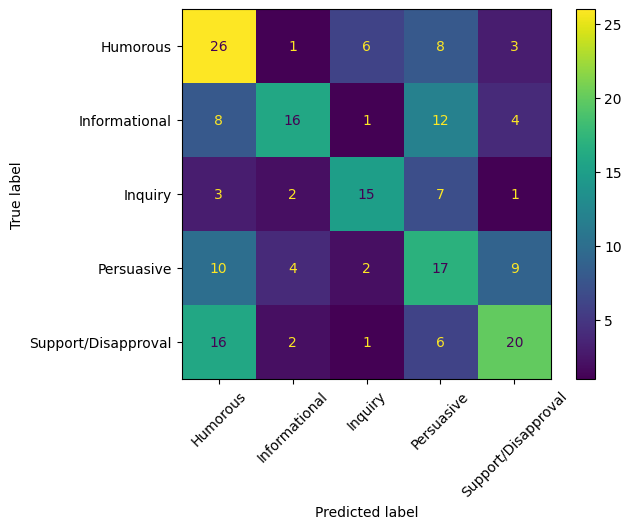


Printing Top Weights...
Humorous	record	0.910
Humorous	're	0.907
Humorous	!	0.875
Humorous	her	0.829
Humorous	she	0.798
Humorous	trying	0.769
Humorous	training	0.733
Humorous	news	0.727
Humorous	back	0.691
Humorous	through	0.686

Informational	https	1.457
Informational	kyrgyzstan	1.054
Informational	4	0.875
Informational	oil	0.783
Informational	could	0.740
Informational	article	0.729
Informational	these	0.714
Informational	anymore	0.708
Informational	first	0.684
Informational	&	0.682

Inquiry	?	3.371
Inquiry	anyone	0.886
Inquiry	must	0.870
Inquiry	with	0.807
Inquiry	why	0.711
Inquiry	wonder	0.694
Inquiry	on	0.648
Inquiry	india	0.629
Inquiry	i	0.546
Inquiry	so	0.544

Persuasive	really	0.940
Persuasive	more	0.891
Persuasive	nuclear	0.868
Persuasive	not	0.863
Persuasive	chose	0.857
Persuasive	make	0.810
Persuasive	good	0.755
Persuasive	war	0.741
Persuasive	sense	0.736
Persuasive	think	0.715

Support/Disapproval	fuck	1.837
Support/Disapproval	corrupt	1.178
Support/Disapproval	wtf	0.998
Su

In [6]:
# Change these variables to point to your data
train_fn = "train.tsv"
dev_fn = "dev.tsv"
test_fn = "test.tsv"

run(train_fn, dev_fn, test_fn)